# Advanced Geometry

When working on the pincell geometry before, we saw how to create cells that are composed of Boolean combinations from surface half-spaces. In principle, this is enough to create pretty much any geometry. However, there are a number of additional functions and classes in the Python API that can greatly simplify how a model is built. In this tutorial, we will leverage features available in the [`openmc.model`](https://docs.openmc.org/en/stable/pythonapi/model.html) module.

In [88]:
import openmc

## Convenience Functions

There is one other function that can simplify the creation of pin-like geometries: `openmc.model.pin`. If you have a fuel pin that consists of multiple concentric cylinders, this function can put together a list of materials and surfaces and return back a fully constructed universe. Let's say we have a pin that consists of fuel, gap, clad, and water.

In [ ]:
clad = openmc.Material()
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 5.0)

water = openmc.Material()
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

Let's use a list comprehension to create some surfaces:

In [90]:
radii = [0.35, 0.4, 0.45]
cyls = [openmc.ZCylinder(r=r) for r in radii]

Now we can create a full fuel pin by passing a list of materials and a list of surfaces that the materials will go between:

In [91]:
fills = [fuel, None, clad, water]
fuel_pin = openmc.model.pin(cyls, fills)
type(fuel_pin)

openmc.universe.Universe

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

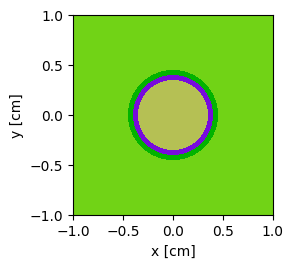

In [92]:
fuel_pin.plot(width=(2.0, 2.0))

## Composite Surfaces

When you create a surface in OpenMC, you get an instance of whatever class you specified. For example, if you call `openmc.XPlane(-5)`, you'll get an `XPlane` object. OpenMC also has several classes that act as "composite" surfaces. What this means is that they can be treated like normal surfaces such that you can use `-` and `+`, but the regions returned by these operators actually are composed from multiple primitive surfaces (planes, quadric, etc.). In this manner, they are equivalent to macrobodies in MCNP.

The currently available list of composite surfaces can be found [here](https://docs.openmc.org/en/stable/pythonapi/model.html#composite-surfaces).

### Rectangular Prism

In [93]:
help(openmc.model.RectangularPrism)

Help on class RectangularPrism in module openmc.model.surface_composite:

class RectangularPrism(CompositeSurface)
 |  RectangularPrism(width: float, height: float, axis: str = 'z', origin: Sequence[float] = (0.0, 0.0), boundary_type: str = 'transmission', albedo: float = 1.0, corner_radius: float = 0.0)
 |  
 |  Infinite rectangular prism bounded by four planar surfaces.
 |  
 |  .. versionadded:: 0.14.0
 |  
 |  Parameters
 |  ----------
 |  width : float
 |      Prism width in units of [cm]. The width is aligned with the x, x, or z
 |      axes for prisms parallel to the x, y, or z axis, respectively.
 |  height : float
 |      Prism height in units of [cm]. The height is aligned with the x, y, or z
 |      axes for prisms parallel to the x, y, or z axis, respectively.
 |  axis : {'x', 'y', 'z'}
 |      Axis with which the infinite length of the prism should be aligned.
 |  origin : Iterable of two floats
 |      Origin of the prism. The two floats correspond to (y,z), (x,z) or (x,y

As we see, this function creates an infinite rectangular prism for us so that we get all four sides without having to define each manually. Let's create a prism of width 10 cm and height 5 cm filled with our water material we created earlier.

In [94]:
prism = openmc.model.RectangularPrism(10., 5.)
type(prism)

openmc.model.surface_composite.RectangularPrism

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

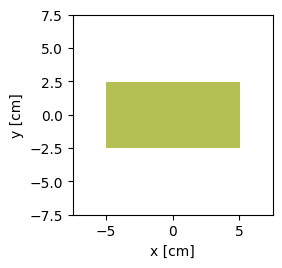

In [95]:
cell = openmc.Cell(fill=water, region=-prism)
univ = openmc.Universe(cells=[cell])

univ.plot(width=(15., 15.))

We can even have rounded corners (fillets) on our prism if we want:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

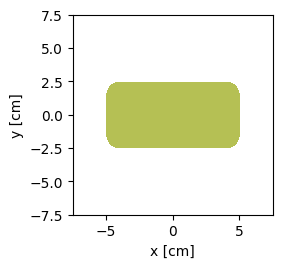

In [96]:
prism = openmc.model.RectangularPrism(10., 5., corner_radius=1.)

cell = openmc.Cell(fill=water, region=-prism)
univ = openmc.Universe(cells=[cell])
univ.plot(width=(15., 15.))

### Hexagonal Prism

Along with rectangular prisms, you can also create a hexagonal prism with the `openmc.model.HexagonalPrism` class, which is very useful for many reactor types. For example, defining a typical hexagonal unit pin cell would look something like the following. Note that the `HexagonalPrism` requires us to tell it the length of the *side* of the hexagon.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

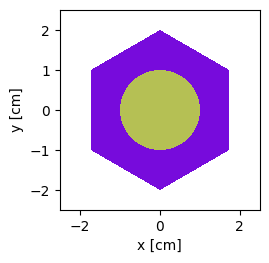

In [97]:
zcyl = openmc.ZCylinder(r = 1.0)
hex_prism = openmc.model.HexagonalPrism(2.0)

pin = openmc.Cell(fill=water, region=-zcyl)
outside_pin = openmc.Cell(region=+zcyl & -hex_prism)
univ = openmc.Universe(cells=[pin, outside_pin])
univ.plot(width=(5., 5.))

You can imagine that in this case, manually defining each of the six planes would be quite laborious! Similar to `RectangularPrism`, the `HexagonalPrism` class allows you to have rounded corners and also allows you to change the "orientation" of the hexagon (flats facing left-right or flats facing up-down).

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

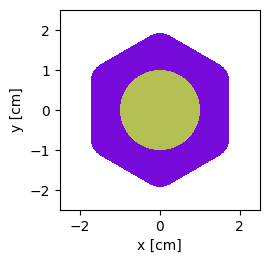

In [98]:
hex_prism = openmc.model.HexagonalPrism(2.0, orientation='y', corner_radius=0.5)

pin = openmc.Cell(fill=water, region=-zcyl)
outside_pin = openmc.Cell(region=+zcyl & -hex_prism)
univ = openmc.Universe(cells=[pin, outside_pin])
univ.plot(width=(5., 5.))

### Isogonal Octagon

As one specific example, the `IsogonalOctagon` composite surface allows you to model an octagon with normal surface-like operations:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

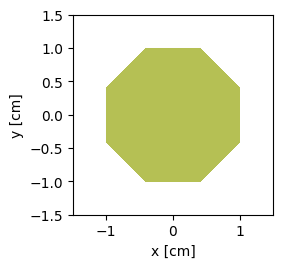

In [99]:
stop_sign = openmc.model.IsogonalOctagon((0., 0.), 1.0, 1.0)
cell = openmc.Cell(fill=water, region=-stop_sign)
univ = openmc.Universe(cells=[cell])
univ.plot(width=(3, 3))

## Other ways of creating surfaces

Sometimes you know what surface you want to define but figuring out all the appropriate coefficients for it can be challenging. For example, the `Plane` class normally requires that you specify the $A$, $B$, $C$, and $D$ coefficients, but it can be a pain to figure these out. Some surface classes in OpenMC have "alternate constructors" that can make creating the surface more intuitive. For `Plane` specifically, there is a `Plane.from_points` classmethod that allows you to provide three points that are on the plane, and it will figure out the appropriate coefficients:

In [100]:
# Create a plane along the line x=y
xy_plane = openmc.Plane.from_points((0., 0., 0.), (1., 1., 0.), (0., 0., 1.))
xy_plane

Surface
	ID                 =	4106
	Name               =	
	Type               =	plane
	Boundary           =	transmission
	Coefficients       
a                   =	1.0
b                   =	-1.0
c                   =	0.0
d                   =	0.0

Similarly, the `Cylinder` class has a `from_points` classmethod that allows you to specify two points going through the axis of the cylinder, which is extremely useful for defining non-axis-aligned cylinders:

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

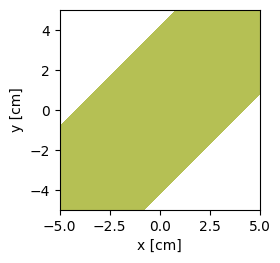

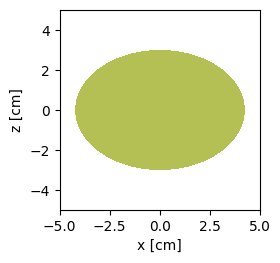

In [101]:
leaning_cylinder = openmc.Cylinder.from_points((0., 0., 0.), (1., 1., 0.), r=3.)
cell = openmc.Cell(fill=water, region=-leaning_cylinder)
univ = openmc.Universe(cells=[cell])
univ.plot(width=(10.0, 10.0))
univ.plot(width=(10.0, 10.0), basis='xz')

Another way that surfaces, particularly ones that are not axis-aligned, can be created is by using the `translate` and `rotate` methods that are available on all surfaces. Another way we could create the cylinder shown above is by creating an axis-aligned cylinder and then rotating it:

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

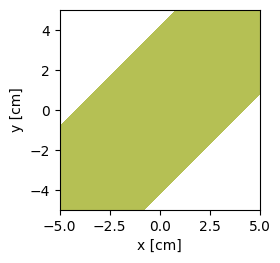

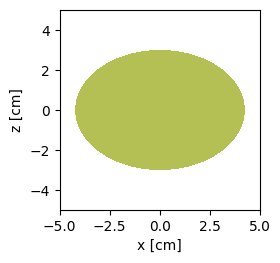

In [102]:
cyl = openmc.YCylinder(r=3.)
rotated_cyl = cyl.rotate((0., 0., -45.))
cell = openmc.Cell(fill=water, region=-rotated_cyl)
univ = openmc.Universe(cells=[cell])
univ.plot(width=(10.0, 10.0))
univ.plot(width=(10.0, 10.0), basis='xz')

## Random sphere packing

OpenMC includes a few convenience functions for generating locations of randomly packed spheres that can be used to model TRISO particles and/or pebbles in a reactor core. To be clear, this capability is not a stochastic geometry capability like that included in MCNP. It's also important to note that OpenMC does not (yet) use delta tracking, which would normally speed up calculations in geometries with tons of surfaces and cells. However, the computational burden can be eased by placing random spheres in a lattice, which we will demonstrate here.

This capability relies on three functions/classes:
- `openmc.model.pack_spheres` -- generate locations of random spheres
- `openmc.model.TRISO` -- Cell-like object that holds a universe storing the internal structure of a pebble/TRISO
- `openmc.model.create_triso_lattice` -- Creates a lattice containing `TRISO` objects for improved tracking performance

Let's start with the `pack_spheres` function. This function takes an outer radius of the spheres, a containing region, and a packing fraction and will return an array of sphere coordinates. For our example, let's use spheres with a radius of 1 cm and a packing fraction of 30%. We'll put our spheres inside of a finite cylinder using another composite surface, `RightCircularCylinder`.

In [103]:
r_cylinder = 10.
h_cylinder = 20.
cylinder = openmc.model.RightCircularCylinder(
    center_base=(0., 0., -10.), 
    height=h_cylinder,
    radius=r_cylinder
)

In [104]:
r_sphere = 1.0
centers = openmc.model.pack_spheres(radius=r_sphere, region=-cylinder, pf=0.3, seed=1)
centers.shape

(449, 3)

We see that with our cylindrical container, the `pack_spheres` function generated 449 locations for spheres. We can look at a few:

In [105]:
centers[:10]

array([[ 1.89582737, -2.69987821,  4.74794314],
       [-4.54352274,  0.13035395, -0.90916083],
       [ 1.75020992, -7.05094292, -7.31052744],
       [ 0.77761353, -1.30056249, -1.21019278],
       [ 7.85709078,  0.10397678, -0.98303051],
       [ 1.01711965,  7.57695257,  8.01487252],
       [ 8.38757093,  1.63226161, -8.5419745 ],
       [ 6.14410702, -2.47070015, -2.13832372],
       [-3.69702725,  1.96889325, -8.47726582],
       [ 0.52110577,  4.31373263, -5.06194133]])

Now we need to actually creates cells for each of these spheres. To do so, we'll use the `TRISO` class. We'll need to define a universe that we want to fill each sphere. For a five-layer TRISO particle, this will be a universe of five annular spheres. Normally, we'd need to make four sphere surfaces and set up the regions between all of these surfaces. We can use another convenience function, `openmc.model.subdivide` to automatically set up these regions for us. Let's assume our TRISO model has five layers,

- $r < 0.5$: layer 1 
- $0.5 < r < 0.6$: layer 2
- $0.6 < r < 0.7$: layer 3
- $0.7 < r < 0.8$: layer 4
- $0.8 < r < 1.0$: layer 5

In order to make this example quicker, note that we're just filling these regions with the `water` and `clad` materials we created earlier, rather than using realistic materials for TRISO particles.

In [106]:
triso_layer_r = [0.5, 0.6, 0.7, 0.8]
sphere_surfs = [openmc.Sphere(r=triso_r) for triso_r in triso_layer_r]

In [107]:
regions = openmc.model.subdivide(sphere_surfs)
print(regions)

[<openmc.surface.Halfspace object at 0x127dfb8d0>, <openmc.region.Intersection object at 0x127ea5890>, <openmc.region.Intersection object at 0x127ea4f10>, <openmc.region.Intersection object at 0x127ea7410>, <openmc.surface.Halfspace object at 0x1275ba790>]


In [108]:
fill_mats = [water, clad, None, water, clad]
cells = []
for i in range(len(regions)):
    cells.append(openmc.Cell(region=regions[i], fill=fill_mats[i]))

In [109]:
sphere_univ = openmc.Universe(cells=cells)

Now we can create a `TRISO` object for each sphere center:

In [110]:
trisos = [openmc.model.TRISO(outer_radius=r_sphere, 
                             fill=sphere_univ, center=center) for center in centers]

Each TRISO object actually is a Cell, in fact; we can look at the properties of the TRISO just as we would a cell:

In [111]:
trisos[0]

Cell
	ID             =	4078
	Name           =	
	Fill           =	310
	Region         =	-4117
	Rotation       =	None
	Translation    =	[ 1.89582737 -2.69987821  4.74794314]
	Volume         =	None

Let's confirm that the packing fraction of our TRISOs is actually about 30%.

In [112]:
from math import pi

volume_trisos = len(trisos)*4/3*pi*r_sphere**3
volume_cyl = pi * r_cylinder**2 * h_cylinder
volume_trisos / volume_cyl

0.2993333333333333

Now that we have our spheres created, we can create a new universe that includes each TRISO as a cell plus a "background" cell that is composed of all space outside of the spheres. We will fill this background by graphite.

In [113]:
graphite = openmc.Material()
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 2.0)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

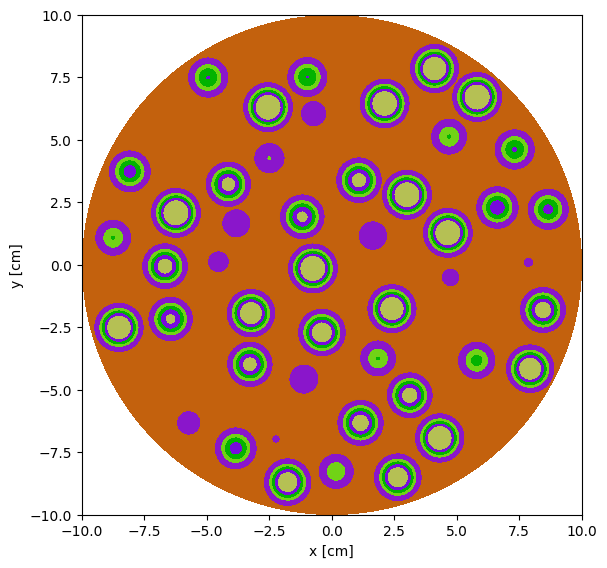

In [114]:
region_background = openmc.Intersection([~t.region for t in trisos])
background_cell = openmc.Cell(region=region_background & -cylinder, fill=graphite)
univ = openmc.Universe(cells=[background_cell] + trisos)
univ.plot(width=(20., 20.), pixels=[500, 500])

While this works in principle, it will lead to **very** poor tracking performance; every time a particle reaches the background cell, it has to determine the distance to the boundary of _every single_ sphere. To improve tracking performance, we can use the `create_triso_lattice` function to overlay a lattice that limits how many distance checks need to be performed.

In [115]:
lower_left, upper_right = (-cylinder).bounding_box
shape = (5, 5, 5)
pitch = (upper_right - lower_left)/shape

lattice = openmc.model.create_triso_lattice(
    trisos=trisos,
    lower_left=lower_left,
    pitch=pitch,
    shape=shape,
    background=graphite
)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

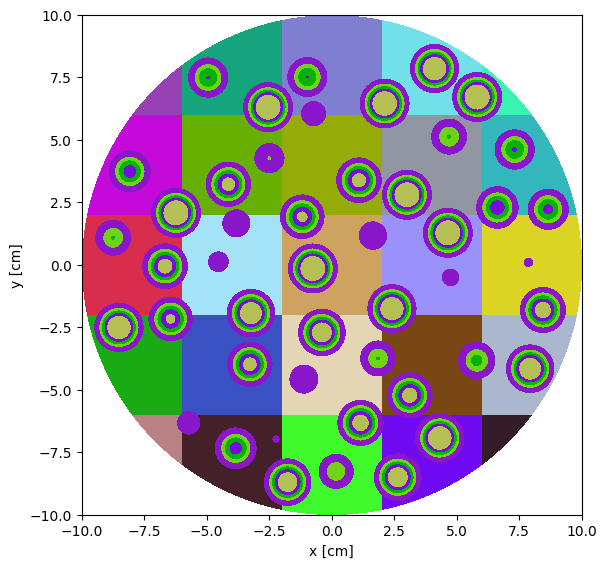

In [116]:
main_cell = openmc.Cell(fill=lattice, region=-cylinder)
univ = openmc.Universe(cells=[main_cell])
univ.plot(width=(20., 20.), pixels=[500, 500])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

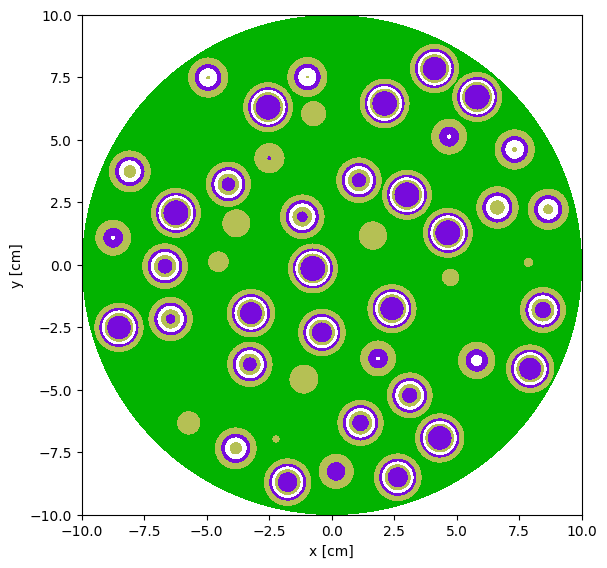

In [117]:
univ.plot(width=(20., 20.), pixels=[500, 500], color_by='material')